# k-evolution test notebook - implementing IC from class

In [1]:
import numpy as np
# import MAS_library as MASL
# import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
# import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 30).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
import scipy.signal as sig
# from scipy.ndimage import gaussian_filter1

# Nested dictionary

In [2]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(5, list)

## Background

In [3]:
As=2.215*1.e-9;
h=0.67556;
kp=0.05/h; 
ns=0.9619;
cs2_e3=1.e-7;
c=2.99792458*1.e5; #Km/s
# Boxsize=320.;
# c_gev=2997.92458; #[100km/s]
# H0_conf_Gev=np.sqrt(Boxsize**2/c**2); #0.10677 rho_crit in Gev=1
H0=100*h/c; #H0 in 1/Mpc unit. 0.00022593979933110373
# print("H0[1/Mpc]=100h/c: ",H0);
w=-0.9;
# print("H0[1/Mpc]=100h/c: ",H0);
def Hubble_conf_Mpc(a):
    c=2.99792458*1.e5;h=0.67556;H0=100*h/c;w=-0.9;
    Omega_b=0.022032/h/h; Omega_cdm=0.12038/h/h;
    Omega_m=Omega_b+Omega_cdm; Omega_Lambda=0;
    Omega_rad=9.1671353942930788e-05; Omega_kessence=1.-Omega_m-Omega_rad;
    return H0*np.sqrt(Omega_m*(a**-3)+Omega_rad*(a**-4)+Omega_kessence*(a**(-3*(1+w))))*a

In [4]:
redshifts = [100, 50, 30,20, 10, 9, 8, 7, 6 , 5, 4, 3, 2.5, 2, 1.5, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0]

address_kev_old = "./unity_c_s2_em7_wm0d9/k_evolution_lightcone_project_using_IC_file/"
for i in range(np.shape(redshifts)[0]):
    data['kev_old']['bg'] = np.loadtxt(address_kev_old+"data__background.dat")
    data['kev_old']['pow_phi']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_phi.dat")
    data['kev_old']['pow_cdm']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_deltacdm.dat")
#     data['kev_old']['pow_ncdm']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_deltancdm.dat")
    data['kev_old']['pow_B']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_B.dat")
    data['kev_old']['pow_pk']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_pi_k.dat")
    data['kev_old']['pow_zeta']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_zeta.dat")
    data['kev_old']['pow_delta_kess']['z='+str(redshifts[i])] = np.loadtxt(address_kev_old+"data_pk_"+str(i).zfill(3)+"_delta_kess.dat")

data['kev_old']['bg'] = np.loadtxt(address_kev_old+"data__background.dat")


address_gev = "./unity_c_s2_em7_wm0d9//gevolution_devel/"

for i in range(np.shape(redshifts)[0]):
    data['gev']['pow_phi']['z='+str(redshifts[i])] = np.loadtxt(address_gev+"data_pk_"+str(i).zfill(3)+"_phi.dat")
    data['gev']['pow_cdm']['z='+str(redshifts[i])] = np.loadtxt(address_gev+"data_pk_"+str(i).zfill(3)+"_deltacdm.dat")
#     data['gev']['pow_ncdm']['z='+str(redshifts[i])] = np.loadtxt(address_gev+"data_pk_"+str(i).zfill(3)+"_deltancdm.dat")
    data['gev']['pow_B']['z='+str(redshifts[i])] = np.loadtxt(address_gev+"data_pk_"+str(i).zfill(3)+"_B.dat")
    data['gev']['pow_delta_kess']['z='+str(redshifts[i])] = np.loadtxt(address_gev+"data_pk_"+str(i).zfill(3)+"_deltaclass.dat")

data['gev']['bg'] = np.loadtxt(address_kev_old+"data__background.dat")

address_kev_dev = "./unity_c_s2_em7_wm0d9/k_evolution_devel//"

for i in range(np.shape(redshifts)[0]):
    data['kev']['pow_phi']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_phi.dat")
    data['kev']['pow_cdm']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_deltacdm.dat")
#     data['kev']['pow_ncdm']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_deltancdm.dat")
    data['kev']['pow_B']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_B.dat")
    data['kev']['pow_pk']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_pi_k.dat")
    data['kev']['pow_zeta']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_zeta.dat")
    data['kev']['pow_delta_kess']['z='+str(redshifts[i])] = np.loadtxt(address_kev_dev+"data_pk_"+str(i).zfill(3)+"_delta_kess.dat")

data['kev']['bg'] = np.loadtxt(address_kev_old+"data__background.dat")


address_class = "./unity_c_s2_em7_wm0d9/class_v2.7.1/"

for i in range(np.shape(redshifts)[0]):
    data['class']['tk']['z='+str(redshifts[i])] = np.loadtxt(address_class+"data_class_z"+str(i+1)+"_tk.dat")

data['class']['bg'] = np.loadtxt(address_class+"data_class_background.dat")


# Background test

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


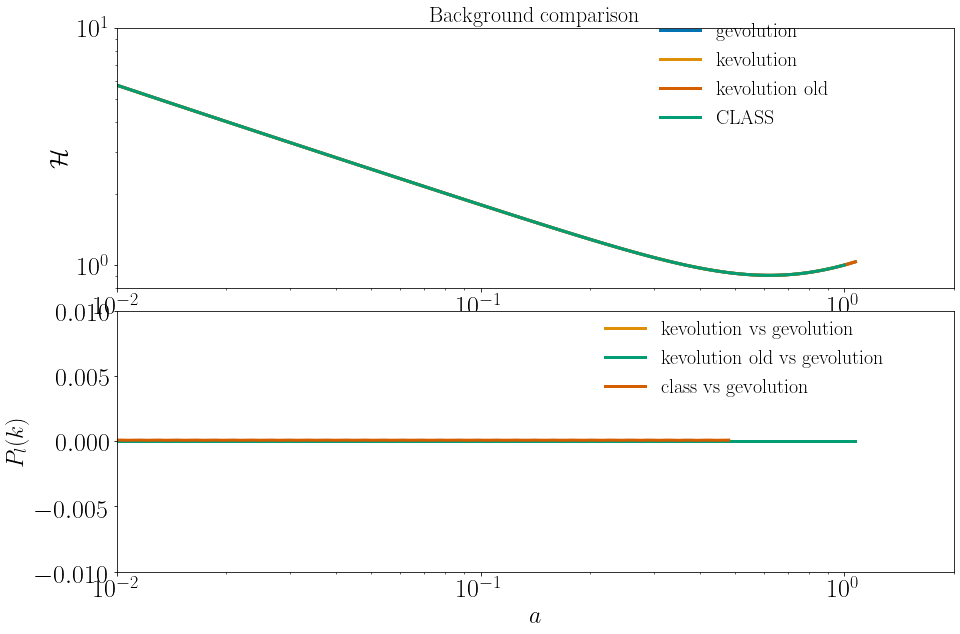

In [5]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,10),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)
l=0
file_gev = data['gev']['bg']
f_gev = interpolate.interp1d(file_gev[:,2],file_gev[:,3])
axs[0].loglog(file_gev[:,2],file_gev[:,3],"-",color =Colors[l], lw=3,label="gevolution")

file = data['kev']['bg']
axs[0].loglog(file[:,2],file[:,3],"-",color =Colors[l+1], lw=3,label="kevolution")

file = data['kev_old']['bg']
axs[0].loglog(file[:,2],file[:,3],"-",color =Colors[l+3], lw=3,label="kevolution old")

file_class = data['class']['bg']
z = file_class[:,0]
a = 1./(1. + z )
f_class = interpolate.interp1d(a, file_class[:,3])

axs[0].loglog(a,file_class[:,3]*a*f_gev(1)/f_class(1),"-",color =Colors[l+2], lw=3,label="CLASS")

axs[0].set_ylabel(r'$\mathcal{H}$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(0.8,1.e1)
axs[0].set_xlim(1.e-2,2.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)



l=0
file_gev = data['gev']['bg']
# axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

file = data['kev']['bg']
axs[1].plot(file[:,2],np.abs(file[:,3]-file_gev[:,3])/file_gev[:,3],"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

file = data['kev_old']['bg']
axs[1].plot(file[:,2],np.abs(file[:,3]-file_gev[:,3])/file_gev[:,3],"-",color =Colors[l+2], lw=3,label="kevolution old vs gevolution")

file = data['kev_old']['bg']
num = np.shape(file_gev[:100,2])[0]-1
a  = file_gev[:num,2]
file_class = f_class(a)*a*f_gev(1)/f_class(1)
axs[1].plot(a,np.abs(file_class-file_gev[:num,3])/file_gev[:num,3],"-",color =Colors[l+3], lw=3,label="class vs gevolution")

axs[1].set_ylabel(r'$P_{l}(k)$',fontsize=24)
axs[1].set_xlabel('$a$',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].set_ylim(-0.01,0.01)
axs[1].set_xlim(1.e-2,2.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


## Numerical background comparison

In [6]:
file1 = data['kev']['bg']
file2 = data['gev']['bg']
file3 = data['kev_old']['bg']
print(np.sum(file1-file2),np.sum( file1-file3), np.sum(file2 -file3)  )
if (np.sum(file1-file2)!=0 or np.sum( file1-file3)!= 0 or  np.sum(file2 -file3) !=0 ):
    print("\x1b[31m\"ERROR - Something is wrong! There is an inconsistency in the BG file\"\x1b[0m")
    

0.0 0.0 0.0


# Matter power spectrum CHECK

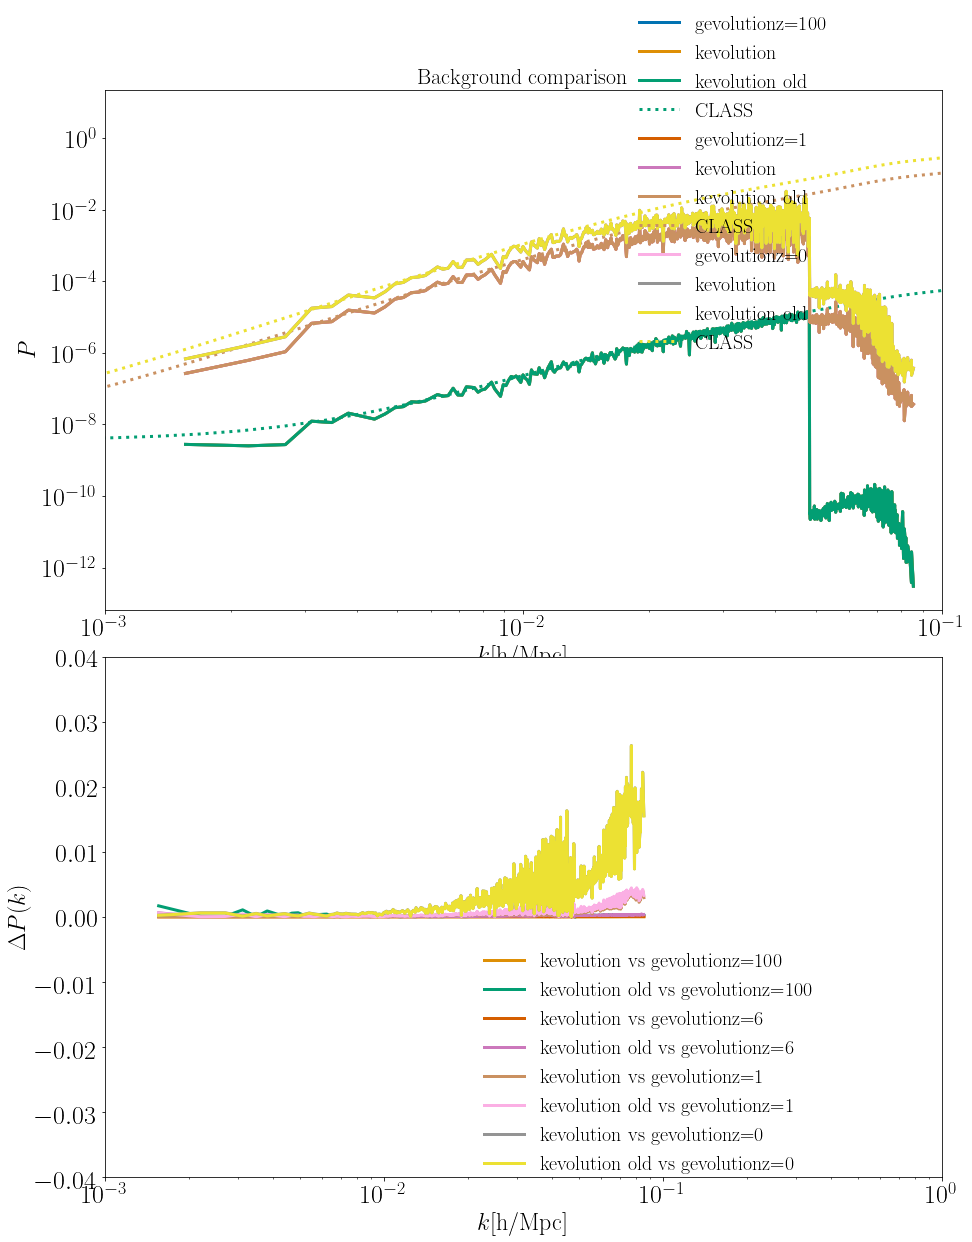

In [7]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_cdm'

Normlization=As*(data['class']['tk']['z='+str(100)][:,0]/kp)**(ns-1.);

for redshift in [100, 1 ,0]:
    file = data['gev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+1], lw=3,label="kevolution")

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+2], lw=3,label="kevolution old")
    
    file = data['class']['tk']['z='+str(redshift)]
    delta_cdm = file[:,3]
    k = file[:,0]
    power = delta_cdm**2 * (Normlization)
    axs[0].loglog(k,power,":",color =Colors[l+2], lw=3,label="CLASS")
    l=l+3

axs[0].set_ylabel(r'$P$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_ylim(0.8,1.e1)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.82],loc="center",frameon=False)


l=0
for redshift in [100,6,1,0]:
#     print(redshift)
    k = data['gev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution"+ 'z='+str(redshift))

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev_old-file_gev)/file_gev,"-",color =Colors[l+2], lw=3,label="kevolution old vs gevolution"+ 'z='+str(redshift))
    l=l+2

axs[1].set_ylabel(r'$\Delta P(k)$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].set_ylim(-0.04,0.04)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.65,0.22],loc="center",frameon=False)


## Numerical test

In [8]:
kind = 'pow_cdm'
for redshift in redshifts:

    k = data['gev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
#     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
    max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
    max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
    max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)

    print("At z:"+ str(redshift) + "\n kevolution vs gevolution max of relative error: " +  str(max_kev_gev) + " at k=" + str(k[where(np.abs(file_kev-file_gev )/file_gev == max_kev_gev)])
         + " \n kevolution_old vs gevolution max of relative error: " + str(max_kev_old_gev)   + " at k=" + str(k[where(np.abs(file_kev_old-file_gev )/file_gev == max_kev_old_gev)])
          + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    


At z:100
 kevolution vs gevolution max of relative error: 0.0 at k=[0.00155833 0.00220381 0.00269911 ... 0.08458156 0.08461027 0.08548117] 
 kevolution_old vs gevolution max of relative error: 0.0016842607244270797 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.0016842607244270797 at k=[0.00155833]
At z:50
 kevolution vs gevolution max of relative error: 8.638995389108605e-07 at k=[0.02835132] 
 kevolution_old vs gevolution max of relative error: 0.000780461324786503 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.000780461324786503 at k=[0.00155833]
At z:30
 kevolution vs gevolution max of relative error: 9.79797554339059e-07 at k=[0.05033911] 
 kevolution_old vs gevolution max of relative error: 0.0006631129144847077 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.0006632868470531928 at k=[0.00155833]
At z:20
 kevolution vs gevolution max of relative error: 1.425182548081852e-06 at k=[0.07265895] 
 kevolut

# Potential power spectrum

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


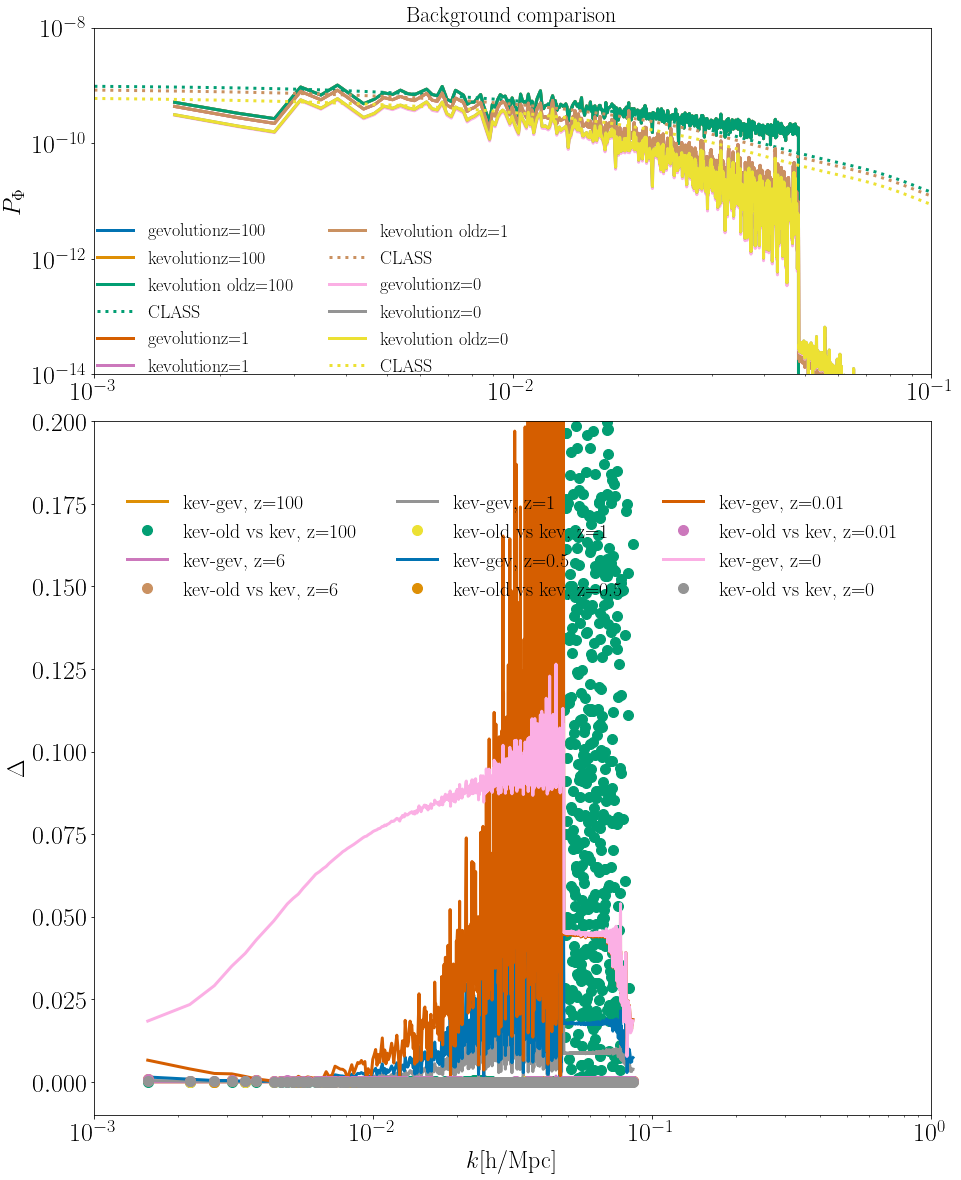

In [9]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1,gridspec_kw={'height_ratios': [1, 2]})
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_phi'
Normlization=As*(data['class']['tk']['z='+str(100)][:,0]/kp)**(ns-1.);

for redshift in [100, 1 ,0]:
    file = data['gev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+1], lw=3,label="kevolution" + 'z='+str(redshift))

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+2], lw=3,label="kevolution old" + 'z='+str(redshift))
    
    file = data['class']['tk']['z='+str(redshift)]
    delta = file[:,9]
    k = file[:,0]
    power = delta**2 * (Normlization)
    axs[0].loglog(k,power,":",color =Colors[l+2], lw=3,label="CLASS")
    l=l+3

axs[0].set_ylabel(r'$P_{\Phi}$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-14,1.e-8)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=18,bbox_to_anchor=[0.25,0.22],ncol=2,loc="center",frameon=False)


l=0
for redshift in [100, 6,1, 0.5,0.01,0]:
#     print(redshift)
    k = data['gev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kev-gev"+ ', z='+str(redshift))

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev_old-file_kev)/file_kev,"o",markersize=10,color =Colors[l+2], lw=3,label="kev-old vs kev"+ ', z='+str(redshift))
    l=l+3

axs[1].set_ylabel(r'$\Delta$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].set_ylim(-0.01,0.2)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5,0.82],ncol=3,loc="center",frameon=False)


## Numerical test

In [10]:
kind = 'pow_phi'
for redshift in redshifts:

    k = data['gev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
#     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
    max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
    max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
    max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)

    print("At z:"+ str(redshift) + "\n kevolution vs gevolution max of relative error: " +  str(max_kev_gev) + " at k=" + str(k[where(np.abs(file_kev-file_gev )/file_gev == max_kev_gev)])
         + " \n kevolution_old vs gevolution max of relative error: " + str(max_kev_old_gev)   + " at k=" + str(k[where(np.abs(file_kev_old-file_gev )/file_gev == max_kev_old_gev)])
          + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    


At z:100
 kevolution vs gevolution max of relative error: 0.0 at k=[0.00155833 0.00220381 0.00269911 ... 0.08458156 0.08461027 0.08548117] 
 kevolution_old vs gevolution max of relative error: 2.748657201846198 at k=[0.073374] 
 kevolution_old vs kevolution max of relative error: 2.748657201846198 at k=[0.073374]
At z:50
 kevolution vs gevolution max of relative error: 1.8759332767926277e-06 at k=[0.08192725] 
 kevolution_old vs gevolution max of relative error: 0.0005813320498764855 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.0005811310582111193 at k=[0.00155833]
At z:30
 kevolution vs gevolution max of relative error: 8.416875836110614e-06 at k=[0.08200132] 
 kevolution_old vs gevolution max of relative error: 0.0006385702538185403 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.0006383666279753402 at k=[0.00155833]
At z:20
 kevolution vs gevolution max of relative error: 2.8362640117216706e-05 at k=[0.04527209] 
 kevolution_old

# B power spectrum

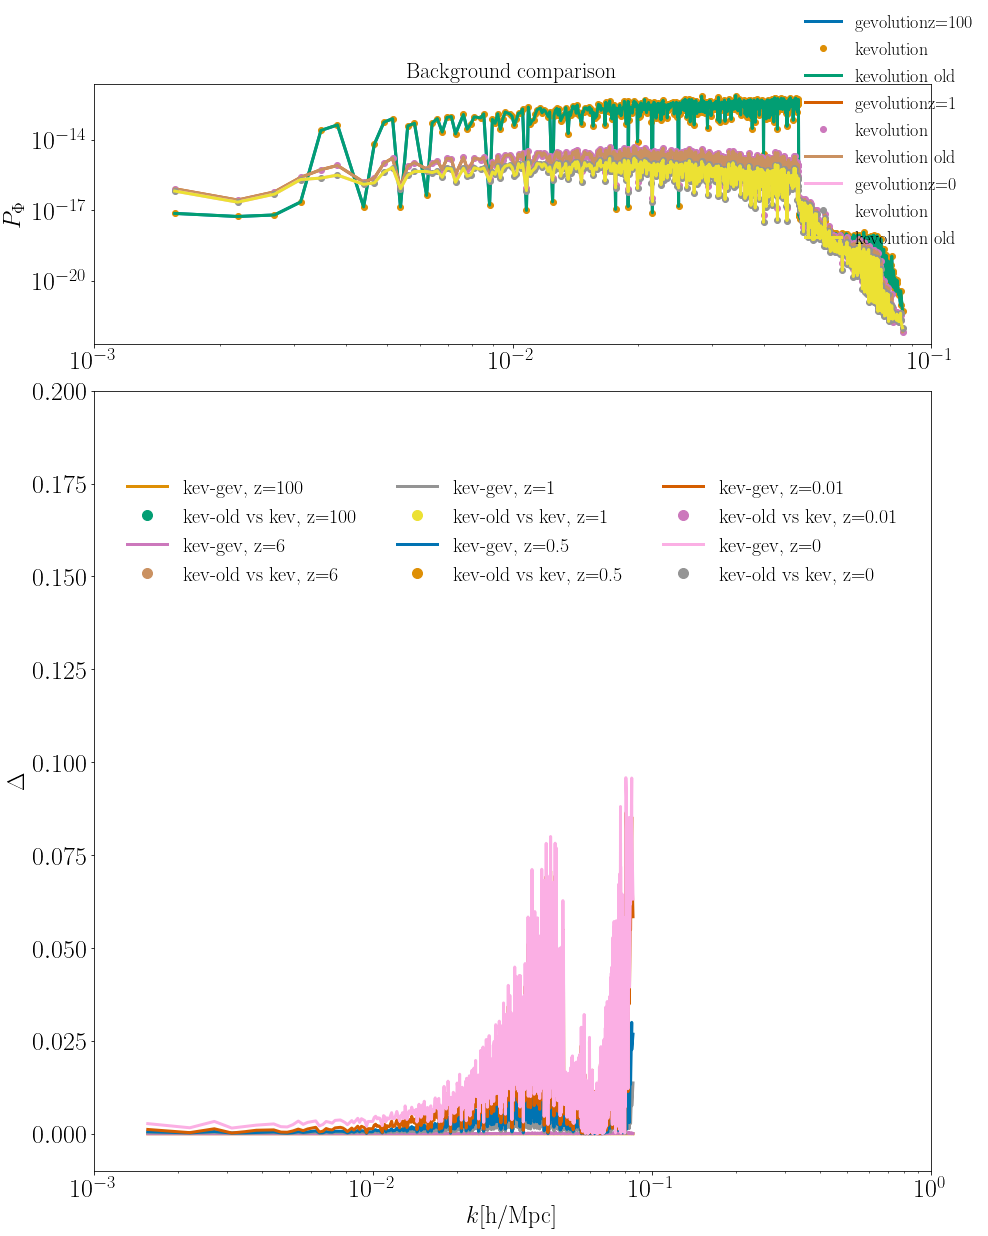

In [11]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1,gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_B'
for redshift in [100, 1 ,0]:
    file = data['gev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"o",color =Colors[l+1], lw=3,label="kevolution")

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+2], lw=3,label="kevolution old")
    l=l+3

axs[0].set_ylabel(r'$P_{\Phi}$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_ylim(0.8,1.e1)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=18,bbox_to_anchor=[0.95,0.82],loc="center",frameon=False)


l=0
for redshift in [100, 6,1, 0.5,0.01,0]:
#     print(redshift)
    k = data['gev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kev-gev"+ ', z='+str(redshift))

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(file[:,2],np.abs(file_kev_old-file_kev)/file_kev,"o",markersize=10,color =Colors[l+2], lw=3,label="kev-old vs kev"+ ', z='+str(redshift))
    l=l+3

axs[1].set_ylabel(r'$\Delta$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
axs[1].set_ylim(-0.01,0.2)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5,0.82],ncol=3,loc="center",frameon=False)


# delta kess

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


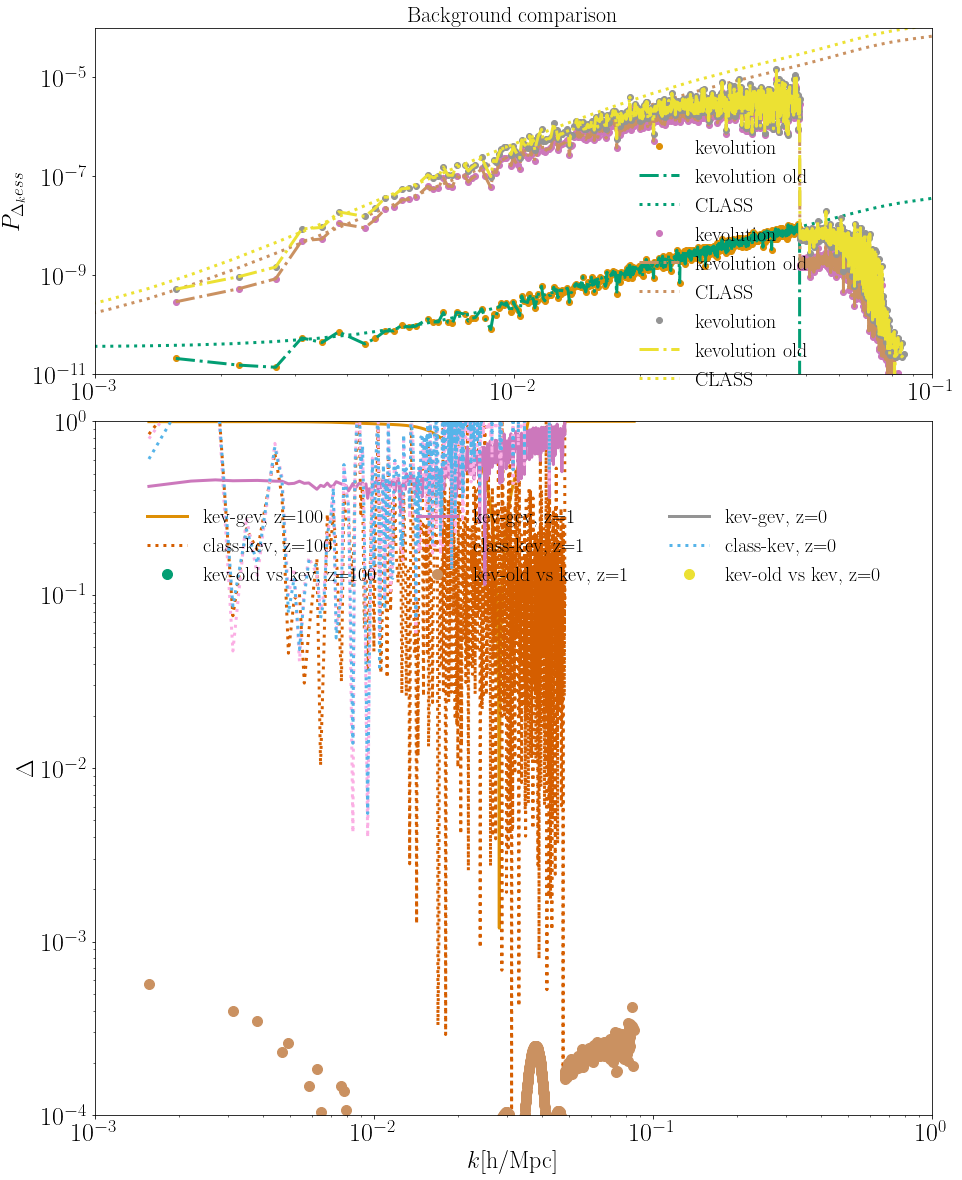

In [17]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1,gridspec_kw={'height_ratios': [1, 2]})
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_delta_kess'
Normlization=As*(data['class']['tk']['z='+str(100)][:,0]/kp)**(ns-1.);

for redshift in [100,1,0]:
#     file = data['gev'][kind]['z='+str(redshift)] 
#     k = file[:,0]
#     axs[0].loglog(k,file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"o",color =Colors[l+1], lw=3,label="kevolution")

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-.",color =Colors[l+2], lw=3,label="kevolution old")
    
    file = data['class']['tk']['z='+str(redshift)]
    delta = file[:,4]
    k = file[:,0]
    power = delta**2 * (Normlization)
    axs[0].loglog(k,power,":",color =Colors[l+2], lw=3,label="CLASS")
    
    l=l+3

axs[0].set_ylabel(r'$P_{\Delta_kess}$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-11,1.e-4)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.75,0.32],loc="center",frameon=False)


l=0
for redshift in [100,1,0]:
#     print(redshift)
    k = data['gev'][kind]['z='+str(redshift)][:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)][:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")
    
    
    
    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kev-gev"+ ', z='+str(redshift))

    
    file = data['class']['tk']['z='+str(redshift)]
    delta = file[:,4]
    k_class = file[:,0]
    power = delta**2 * (Normlization)
    f_kess_class = interpolate.interp1d(k_class, power)
    file_class = f_kess_class(k)
    axs[1].plot(k,np.abs(file_class-file_kev)/file_kev,":",color =Colors[l+3], lw=3,label="class-kev"+ ', z='+str(redshift))


    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev_old-file_kev)/file_kev,"o",markersize=10,color =Colors[l+2], lw=3,label="kev-old vs kev"+ ', z='+str(redshift))
    l=l+3

axs[1].set_ylabel(r'$\Delta$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1.e-4,1)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5,0.82],ncol=3,loc="center",frameon=False)


## Numerical test:

In [21]:
kind = 'pow_B'
for redshift in redshifts:

    k = data['kev'][kind]['z='+str(redshift)] [:,0]
    file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
#     axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
    
    file = data['class']['tk']['z='+str(redshift)]
    delta = file[:,4]
    k_class = file[:,0]
    power = delta**2 * (Normlization)
    f_kess_class = interpolate.interp1d(k_class, power)
    file_class = f_kess_class(k)

#     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
    max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
    max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
    max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)
    max_class_kev = np.max(np.abs(file_class-file_kev )/file_kev)

    

    print("At z:"+ str(redshift) + "\n kevolution vs gevolution max of relative error: " +  str(max_kev_gev) + " at k=" + str(k[where(np.abs(file_kev-file_gev )/file_gev == max_kev_gev)])
         + " \n kevolution_old vs gevolution max of relative error: " + str(max_kev_old_gev)   + " at k=" + str(k[where(np.abs(file_kev_old-file_gev )/file_gev == max_kev_old_gev)])
#          + " \n class vs kevolution max of relative error: " + str(max_class_kev)   + " at k=" + str(k[where(np.abs(file_class-file_kev )/file_kev == max_class_kev)])
          + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    


At z:100
 kevolution vs gevolution max of relative error: 0.0 at k=[0.00155833 0.00220381 0.00269911 ... 0.08458156 0.08461027 0.08548117] 
 kevolution_old vs gevolution max of relative error: 0.00030034057358201523 at k=[0.00155833] 
 kevolution_old vs kevolution max of relative error: 0.00030034057358201523 at k=[0.00155833]
At z:50
 kevolution vs gevolution max of relative error: 9.864549866201594e-07 at k=[0.0764782] 
 kevolution_old vs gevolution max of relative error: 0.0002884413557973234 at k=[0.00220381] 
 kevolution_old vs kevolution max of relative error: 0.0002882136332333061 at k=[0.00220381]
At z:30
 kevolution vs gevolution max of relative error: 1.4734104663384365e-06 at k=[0.0449491] 
 kevolution_old vs gevolution max of relative error: 0.0003316258058766276 at k=[0.00220381] 
 kevolution_old vs kevolution max of relative error: 0.0003316258058766276 at k=[0.00220381]
At z:20
 kevolution vs gevolution max of relative error: 5.851228611749822e-06 at k=[0.08548117] 
 kev

# pi_k power spectrum

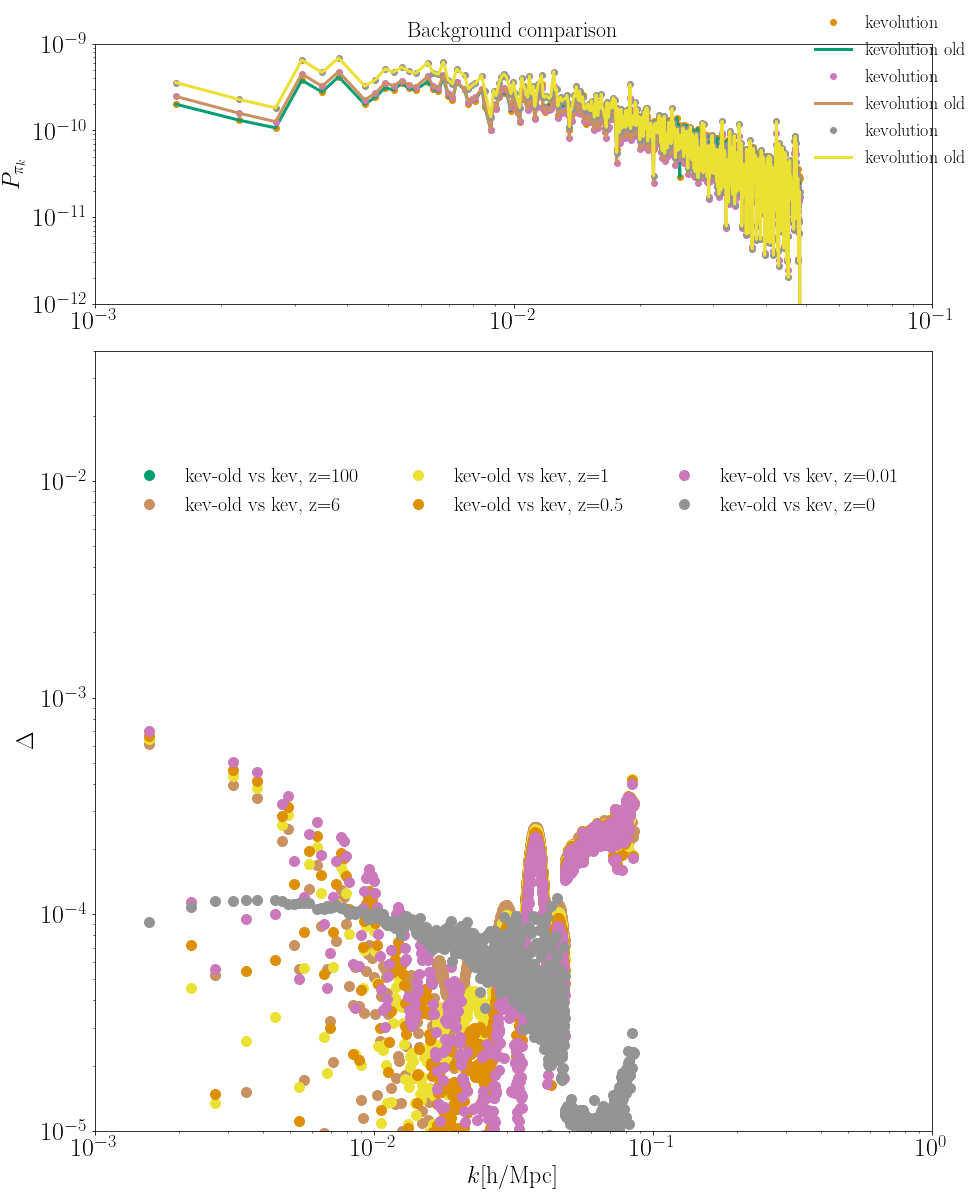

In [24]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1,gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_pk'
for redshift in [100, 1 ,0]:
#     file = data['gev'][kind]['z='+str(redshift)] 
#     axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"o",color =Colors[l+1], lw=3,label="kevolution")

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+2], lw=3,label="kevolution old")
    l=l+3

axs[0].set_ylabel(r'$P_{\pi_k}$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1.e-12,1.e-9)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=18,bbox_to_anchor=[0.95,0.82],loc="center",frameon=False)


l=0
for redshift in [100, 6,1, 0.5,0.01,0]:
#     print(redshift)
    k = data['kev'][kind]['z='+str(redshift)] [:,0]
#     file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
#     # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
#     axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kev-gev"+ ', z='+str(redshift))

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev_old-file_kev)/file_kev,"o",markersize=10,color =Colors[l+2], lw=3,label="kev-old vs kev"+ ', z='+str(redshift))
    l=l+3

axs[1].set_ylabel(r'$\Delta$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1.e-5,0.04)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5,0.82],ncol=3,loc="center",frameon=False)


## numerical check

In [25]:
kind = 'pow_pk'
for redshift in redshifts:

#     k = data['gev'][kind]['z='+str(redshift)] [:,0]
#     file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
#     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
    max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
    max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
    max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)

    print("At z:"+ str(redshift) + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    


At z:100 
 kevolution_old vs kevolution max of relative error: 0.0 at k=[0.00155833 0.00220381 0.00269911 ... 0.08458156 0.08461027 0.08548117]
At z:50 
 kevolution_old vs kevolution max of relative error: 0.00031724686273393825 at k=[0.07460478]
At z:30 
 kevolution_old vs kevolution max of relative error: 0.00046194195133117643 at k=[0.00155833]
At z:20 
 kevolution_old vs kevolution max of relative error: 0.0005415991614792938 at k=[0.00155833]
At z:10 
 kevolution_old vs kevolution max of relative error: 0.0005968030336014743 at k=[0.00155833]
At z:9 
 kevolution_old vs kevolution max of relative error: 0.0006006307552698436 at k=[0.00155833]
At z:8 
 kevolution_old vs kevolution max of relative error: 0.0006038944689769091 at k=[0.00155833]
At z:7 
 kevolution_old vs kevolution max of relative error: 0.000606508058854113 at k=[0.00155833]
At z:6 
 kevolution_old vs kevolution max of relative error: 0.0006088068497719739 at k=[0.00155833]
At z:5 
 kevolution_old vs kevolution max o

# zeta power

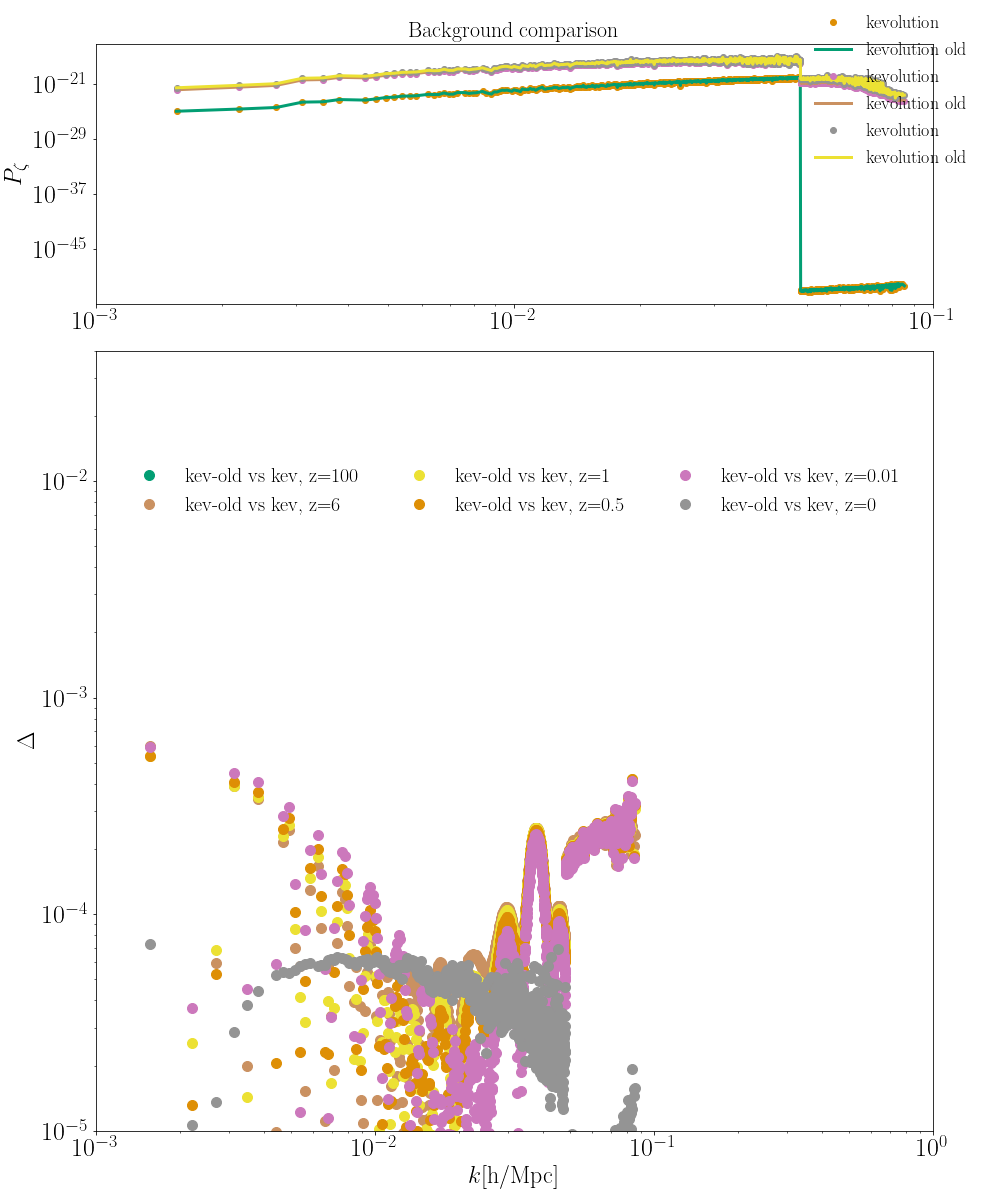

In [26]:
# plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(15,20),nrows=2, ncols=1,gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.09)
l=0
kind = 'pow_zeta'
for redshift in [100, 1 ,0]:
#     file = data['gev'][kind]['z='+str(redshift)] 
#     axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l], lw=3,label="gevolution" + 'z='+str(redshift))

    file = data['kev'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"o",color =Colors[l+1], lw=3,label="kevolution")

    file = data['kev_old'][kind]['z='+str(redshift)] 
    axs[0].loglog(file[:,0],file[:,1],"-",color =Colors[l+2], lw=3,label="kevolution old")
    l=l+3

axs[0].set_ylabel(r'$P_{\zeta}$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_ylim(1.e-12,1.e-9)
axs[0].set_xlim(1.e-3,1.e-1)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
axs[0].set_title("Background comparison", fontsize=22)
axs[0].legend(fontsize=18,bbox_to_anchor=[0.95,0.82],loc="center",frameon=False)


l=0
for redshift in [100, 6,1, 0.5,0.01,0]:
#     print(redshift)
    k = data['kev'][kind]['z='+str(redshift)] [:,0]
#     file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
#     # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
#     axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kev-gev"+ ', z='+str(redshift))

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev_old-file_kev)/file_kev,"o",markersize=10,color =Colors[l+2], lw=3,label="kev-old vs kev"+ ', z='+str(redshift))
    l=l+3

axs[1].set_ylabel(r'$\Delta$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1.e-5,0.04)
axs[1].set_xlim(1.e-3,1.e0)
# axs.legend(fontsize=16,bbox_to_anchor=(0.50,0.53))
# axs[1].set_title("Background comparison", fontsize=22)
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5,0.82],ncol=3,loc="center",frameon=False)


## Numerical check

In [27]:
kind = 'pow_zeta'
for redshift in redshifts:

#     k = data['gev'][kind]['z='+str(redshift)] [:,0]
#     file_gev = data['gev'][kind]['z='+str(redshift)] [:,1]
    # axs[1].loglog(file[:,2],file[:,3],"-",color =Colors[l], lw=3,label="gevolution")

    file_kev = data['kev'][kind]['z='+str(redshift)][:,1]
    axs[1].plot(k,np.abs(file_kev-file_gev)/file_gev,"-",color =Colors[l+1], lw=3,label="kevolution vs gevolution")

    file_kev_old = data['kev_old'][kind]['z='+str(redshift)][:,1]
    
#     print("At z:"+ str(redshifts[i]) + "\n kevolution vs gevolution max of relative error: " +  str(np.max(file_kev-file_gev )) + " \n kevolution_old vs gevolution max of relative error: " + np.max(file_kev_old-file_gev ) + " \n kevolution_old vs kevolution max of relative error: " + np.max(file_kev_old-file_kev ) )
    max_kev_gev = np.max(np.abs(file_kev-file_gev )/file_gev)
    max_kev_old_gev = np.max(np.abs(file_kev_old-file_gev )/file_gev)
    max_kev_old_kev = np.max(np.abs(file_kev_old-file_kev )/file_kev)

    print("At z:"+ str(redshift) + " \n kevolution_old vs kevolution max of relative error: " + str(max_kev_old_kev)  + " at k=" + str(k[where(np.abs(file_kev_old-file_kev )/file_kev == max_kev_old_kev)]))
    


At z:100 
 kevolution_old vs kevolution max of relative error: 0.0 at k=[0.00155833 0.00220381 0.00269911 ... 0.08458156 0.08461027 0.08548117]
At z:50 
 kevolution_old vs kevolution max of relative error: 0.011338352971073934 at k=[0.00155833]
At z:30 
 kevolution_old vs kevolution max of relative error: 0.003060297596472941 at k=[0.00155833]
At z:20 
 kevolution_old vs kevolution max of relative error: 0.0005189451526136713 at k=[0.00155833]
At z:10 
 kevolution_old vs kevolution max of relative error: 0.00051866487057591 at k=[0.00155833]
At z:9 
 kevolution_old vs kevolution max of relative error: 0.0005531500540791248 at k=[0.00155833]
At z:8 
 kevolution_old vs kevolution max of relative error: 0.0005780732662499326 at k=[0.00155833]
At z:7 
 kevolution_old vs kevolution max of relative error: 0.0005951510668855918 at k=[0.00155833]
At z:6 
 kevolution_old vs kevolution max of relative error: 0.0006009428859919786 at k=[0.00155833]
At z:5 
 kevolution_old vs kevolution max of rel